### установка основной рабочей библиотеки

In [3]:
#pip install pymc

### установка основной библиотеки визуализации

In [6]:
# pip install arviz

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

In [10]:
print(pm.__version__)
print(az.__version__)

5.16.2
0.19.0


## Решение задачи о подбрасывании монет с использованиембиблиотеки PyMC

Вернемся к задаче о подбрасывании монеты, теперь используем для ее решения библиотеку PyMC. Воспользуемся теми же синтезированными данными. Поскольку данные генерируются, нам известно истинное значение параметра $theta$, который имеет имя <code>theta_real</code> в приведенном ниже коде. Разумеется, для реального набора данных значение этого параметра будет неизвестным.

In [14]:
np.random.seed(123)
trials = 100
theta_real = 0.35 # в реальном эксперименте это значение неизвестно 
data = stats.bernoulli.rvs(p=theta_real, size=trials)
data

array([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0])


Определим нашу модель. Напомним, что этот процесс включает определение функции правдоподобия и априорной вероятности с использованием распределений вероятностей. 

Для функции правдоподобия воспользуемся биномиальным распределением с параметрами $n = 1$ и $p = \theta$, а для априорной вероятности применим бета-распределение с параметрами $\alpha = \beta = 1$. Бета-распределение с такими параметрами равнозначно равномерному распределению в интервале [0,1]. В математической нотации можно записать эту модель следующим образом:
$$\theta \sim Beta (\alpha , \beta)$$
$$y \sim Bern (n=1, p= \theta)$$

Преобразуем данную статистическую модель практически без изменений в код:


Кстати как писать греческие буквы? Пишем код `LaTex` и нажимаем `tab`<br>
\alpha и далее `Tab` в результате $\alpha$<br> 
\theta и далее `Tab` в результате $\theta$<br>


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.304,0.045,0.22,0.388,0.001,0.001,1809.0,2824.0,1.0


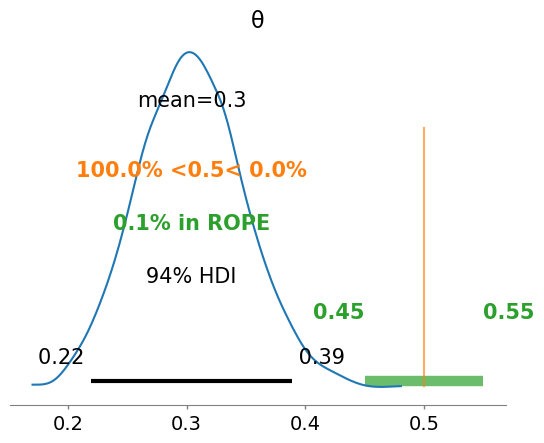

In [17]:
with pm.Model() as our_first_model:
    # a priori
    θ = pm.Beta('θ', alpha=1., beta=1.)
    # likelihood
    y = pm.Bernoulli('y', p=θ, observed=data) 
    trace = pm.sample(1000, random_seed = 43, chains=4, cores = 4)

az.plot_posterior(trace, ref_val=0.5,rope=[0.45, .55]);
az.summary(trace)

В первой строке кода создается контейнер для используемой модели. Весь код, расположенный внутри блока <code>with</code>, автоматически добавляется в объект <code>our_first_model</code>.

Во второй строке определяется априорная вероятность. Как видите, синтаксис очень похож на математическую нотацию.

В третьей строке определяется функция правдоподобия. Синтаксис почти тот же, что при определении априорной вероятности, за исключением того, что данные передаются с использованием аргумента <code>observed</code>. Это способ, которым мы сообщаем библиотеке PyMC о том, что необходимо определить условие для неизвестного по известному (data). Наблюдаемые значения могут быть переданы как список языка Python, кортеж, массив NumPy или DataFrame из Pandas.

В четвертой строке «кнопка статистического вывода», запрашиваем 1000 элементов выборки из апостериорного распределения и сохраняем их в объекте trace. 

Разберем сообщение, получаемое после срабатывания кода.

В первой и второй строках сообщается, что PyMC автоматически выбирает для применения сэмплер NUTS (один из механизмов статистического вывода, который очень хорошо подходит для работы с непрерывными переменными) и использует указанный метод для инициализации этого сэмплера. Поздее разберемся в его настройках.

Третья строка говорит о том, что PyMC будет параллельно обрабатывать три цепочки, следовательно, мы получим три независимые выборки из апостериорного распределения. Это число можно изменить, восользовавшись аргументом <code>chains</code>  в функции <code>sample</code>. Также чепочки желательно раздавать на отдельные вычислительные ядра. Если `cores` равно 1, по цепочки посчитаются последовательно, если `None`, то раздадутся на не более чем 4 четыре процессорных ядра.

В четвертой указываются названия моделируемой переменной.

Далее зеленым цветом индикатор процесса обработки переменной.

Окуда взялась цифра 6000? По 1000 элементов в каждой цепочке предназначено для автоматической точной настройки алгоритма выборки `tune`. Эта часть выборки неиспользуется в построении модели. Далее в каждой цепочке обрабатывается 1000 элементов (`draws`), дающих итоговый результат, таким образом всего генерируется 6000 элементов.
Этап точной настройки помогает PyMC формировать надежную выборку из апостериорного распределения. Количество этапов точной настройки можно изменить с помощью аргумента <code>tune</code> и <code>draws</code> в функции <code>sample</code>.

Для визуализации и анализа полученных результатов идеально подходит библиотека ArviZ.

Используя функцию <code>az.plot_trace</code>, мы получаем три отдельных графика для каждой цепочке расчетов для ненаблюдаемой переменной. В нашей модели единственной такой переменной является $\theta$. Отметим, что $y$ – это наблюдаемая переменная, представленная данными, поэтому нет необходимости создавать по ней выборку, так как нам уже известны ее значения.

Слева изображен график ядерной оценки плотности (ЯОП), представляющий собой сглаженную версию гистограммы. Справа приведены отдельные значения элементов выборки на каждом шаге процесса сэмплирования. По такому трассировочному графику можно визуально получить правдоподобные значения из апостериорного распределения.

Вы должны сравнить этот результат применения библиотеки PyMC с результатом, полученным аналитическим методом ранее.

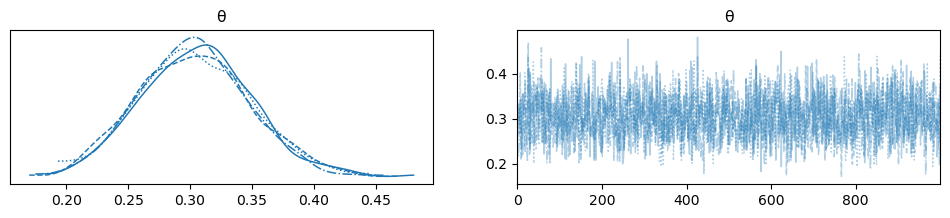

In [19]:
az.plot_trace(trace);

Результат трассировки можно представить в числовом виде. ля этого можно воспользоваться функцией <code>az.summary</code>, которая возвращает объект DataFrame библиотеки pandas:

In [21]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,0.304,0.045,0.22,0.388,0.001,0.001,1809.0,2824.0,1.0


Здесь мы получаем среднее значение (mean), стандартное отклонение (sd) и интервал 94 % плотности апостериорного распределения (ПАР (HDI) – hpd 3 % и hpd 97 %). Остальные  метрики относятся к диагностированию выборок (о них будем говорить значительно позднее или никогда :)). 

Давайте разберемся, что такое  ПАР.

Результатом байесовского анализа является апостериорное распределение, а вся информация о параметрах исследуемого набора данных и модели содержится в апостериорном распределении. Таким образом, обобщая апостериорное распределение, мы обобщаем логические выводы о модели и о данных. Общепринятым практическим методом является отчет по каждому параметру с указанием среднего значения (или медианы) для получения общего представления о размещении распределения и некоторой меры, например такой, как стандартное (среднеквадратическое) отклонение, а также для получения представления о вариации, следовательно, о неопределенности полученной оценки. <br>
Стандартное отклонение хорошо подходит для распределений нормального типа, но может оказаться ошибочным для других типов распределений, таких как асимметричные распределения.

Широко применяемым приемом для обобщения размаха апостериорного распределения является использование интервала плотности апостериорного распределения (Highest-Posterior Density – HPD). Интервал плотности апостериорного распределения (ПАР) – это самый короткий интервал, содержащий определенную часть плотности распределения. Чаще всего применяется интервал ПАР 95 %, часто дополняемый 50%-ным интервалом ПАР. Если интервал ПАР 95 % для некоторого анализа лежит в пределах [2,5], то для исследуемых данных и используемой модели можно считать, что рассматриваемый параметр имеет значение в интервале от 2 до 5 с вероятностью 0.95.

Почему ArviZ установлено 94%, а не 95%, а просто так удобнее, меньше цифр (100-96)/2=3. Надеюсь понятно, почему появились и что, значат цифры hpd_3% и hpd_97%. 

Визуально можно построить апостериорное распределения для лучшего результата (максимальной высоты) использую команду <code>az.plot_posterior</code> с отображением ПАР 94% в виде толстой черной линии.

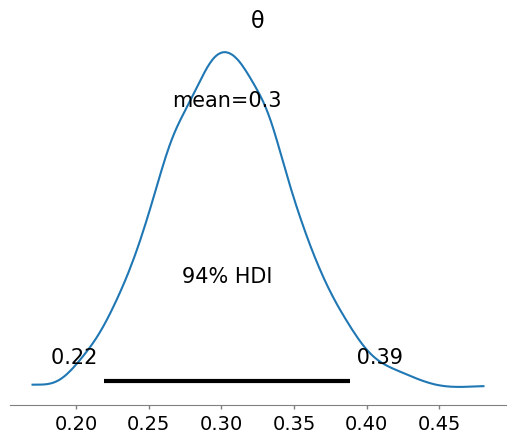

In [23]:
az.plot_posterior(trace);

Если наша монета симетрична,то можно утверждать практически, что любое значение в интервале [0.45, 0.55] будет практически равным 0.5 и представлять собой приемлемое решение нашей задачи. 

Этот интервал называют пространством практической равнозначности (ППР) (Region of Practical Equivalence – ROPE). После определения ППР, сравниваем его с плотностью апостериорного распределения (ПАР). 

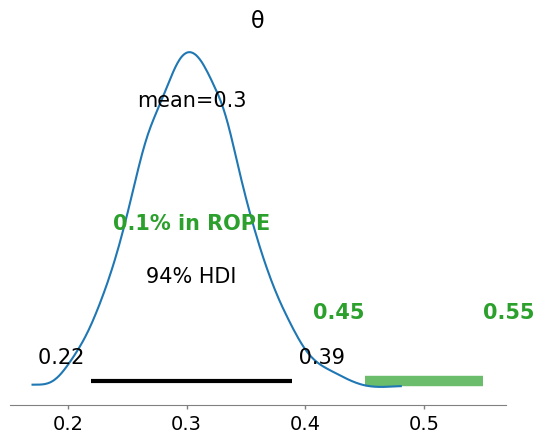

In [25]:
az.plot_posterior(trace, rope=[0.45, .55]);

При таком сравнении возможны как минимум три варианта:
<ul>
<li>
ППР не пересекается с ПАР, поэтому можно утверждать, что монета несимметрична;
</li>
<li>
    ППР полностью включает в себя весь интервал ПАР, поэтому можно утверждать, что монета симметрична;
</li>
<li>
        ППР частично пересекается с ПАР, при этом невозможно точно определить симметричность или несимметричность монеты
</li>
</ul>

Внимание! Не существует какого-либо суперуниверсального правила, соответствующего намерениям и предположениям каждого испытателя. Любые решения субъективны по своей природе, и наша цель – определить самые обоснованные (то есть принятые на основе наиболее полной информации) возможные решения, соответствующие нашим целям.

Кроме того, можно использовать другой инструмент, помогающий принять решение, – сравнение апостериорного распределения с эталонным значением (конечно, если оно существует).

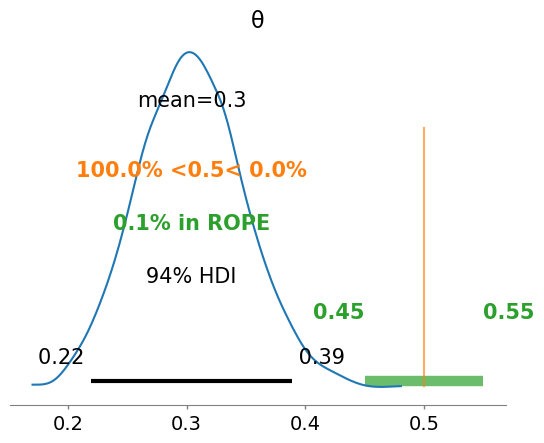

In [28]:
az.plot_posterior(trace, ref_val=0.5,rope=[0.45, .55]);

###  Попытка написания своей модельки

Давайте попробуем собрать абстрактную модель исходя из следующих условий:
    
$$
\begin{gather*}
y_i \sim Normal(\mu, \sigma)\\
\mu \sim Normal(0,10)\\
\sigma \sim HalfNormal(25)
\end{gather*}
$$   

при этом наблюденные данные сгенерированы на 10 000 точек исходя из $y \sim Normal(0, 5)$

Где здесь априорная вероятность, а где правдопобобие? Напишем код?